An attempt to use astroscrappy to extract cosmic rays from a pre-processed BAM-file

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.io import fits
import astroscrappy

In [3]:
sourcefile=("../../datasets/bam_sif_extracted_ralf/2014-05/CR_000017380011161851100_2014-05-18.fits")
#sourcefile=("../../datasets/bam_sif_extracted_ralf/2014-05/CR_000018330454284134300_2014-05-29.fits")
rawdat = fits.getdata(sourcefile)
print(rawdat.shape)

(721, 141)


# To be done: AXIS1[0] and AXIS2[0] are bias and noise reference and must be properly treated

For now though, let's just try the algorithm...

In [4]:
rawdat = rawdat[1:,1:]

# Generation of a cosmic ray mask

In [5]:
# let's get the gain
gain = fits.getheader(sourcefile)["CONVGAIN"]
import re as regex # CONVGAIN is a string including the unit, which I need to somehow remove
                   # WHY is the unit not simply in the comment!?
print(gain)
print("removing units and converting to float...")
gain = float(regex.search("[0-9.]+(?= e-/ADU)",gain).group(0))
print(gain)

3.853 e-/ADU
removing units and converting to float...
3.853


In [6]:
# run the algorithm
# use the default values and those pointed out to get it
# most similar to LA Cosmic
(mask,clean) = astroscrappy.detect_cosmics(rawdat, gain=gain, verbose=True,
                                           inmask=None, satlevel=np.inf, sepmed=False, 
                                           cleantype='medmask', fsmode='median')

Starting 4 L.A.Cosmic iterations
Iteration 1:
316 cosmic pixels this iteration
Iteration 2:
11 cosmic pixels this iteration
Iteration 3:
0 cosmic pixels this iteration




Let's look at the data...

In [7]:
from matplotlib.colors import LogNorm

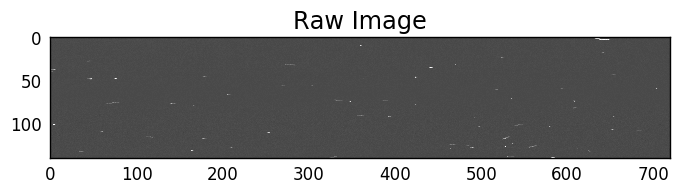

In [8]:
plt.imshow(np.rot90(rawdat,1),cmap='gray',norm=LogNorm(),vmin=1e3,vmax=4e3)
plt.title("Raw Image")
plt.grid(False)

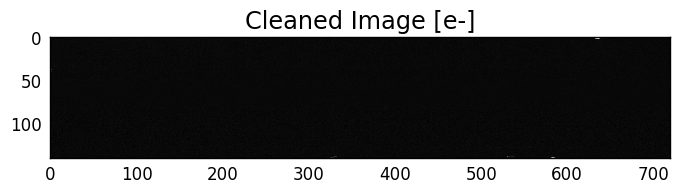

In [9]:
plt.imshow(np.rot90(clean,1),cmap='gray',norm=LogNorm())
plt.title("Cleaned Image [e-]")
plt.grid(False)

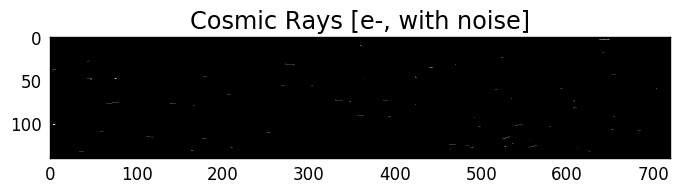

In [10]:
plt.imshow(np.rot90(gain*mask*rawdat,1),cmap='gray')
plt.title("Cosmic Rays [e-, with noise]")
plt.grid(False)

Now let's consider some basic statistics...

In the cleaned image, the cosmics have been replaced by the local background.
So, this way, we should get only the cosmics:

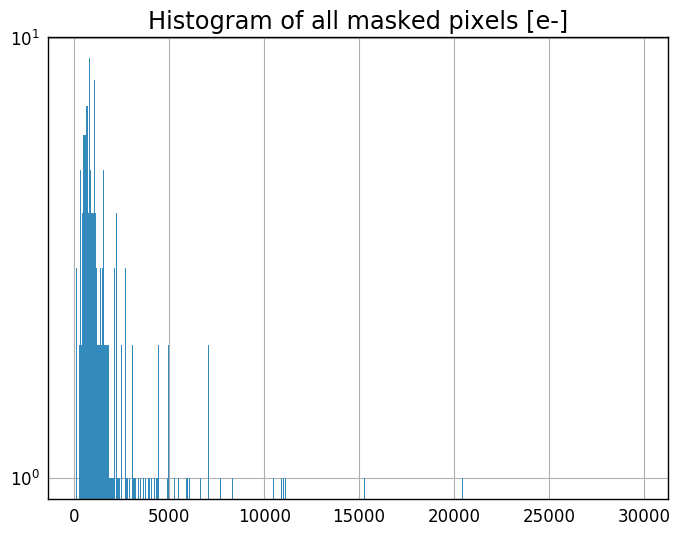

In [133]:
cosmics = (rawdat*gain - clean)
NBINS=1000
histogram = plt.hist(cosmics[mask], NBINS,log=True) # need to select mask so that we don't just get zeros
plt.title("Histogram of all masked pixels [e-]")

# Separating single events

Now let's try to actually extract cosmics as single events.
cosmics.py uses a combination of a few functions from scipy.ndimage - let's try the same

In [12]:
import scipy.ndimage as ndimage

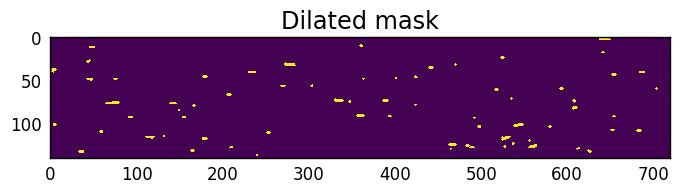

In [92]:
# binary dilation, though it might not be necessary

#dilation_struct = np.ones((3,3))   # vertical, horiz. and diagonal neighbours
dilation_struct = ndimage.generate_binary_structure(2, 1) # just horiz. and vertical

dilmask = ndimage.morphology.binary_dilation(mask, structure=dilation_struct, iterations=1)
#dilmask = mask

plt.imshow(np.rot90(dilmask,1))
plt.title("Dilated mask")
plt.grid(False)

Regarding dilation: My fear is that these dilated cosmics can actually cover more than one event. 

This would screw up our statistics, and I honestly don't see why we should not just do the labeling by including diagonal neighbours - I don't expect tracks that leave empty spaces inbetween, they should always be connected

Number of events: 70


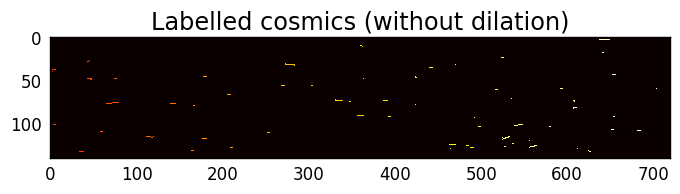

In [120]:
# labelling

(labels, ntracks) = ndimage.measurements.label(mask,structure=(np.ones((3,3))))
#(labels, ntracks) = ndimage.measurements.label(mask,structure=[[0,1,0],[1,1,1],[0,1,0]])
#(labels, ntracks) = ndimage.measurements.label(dilmask,structure=[[0,1,0],[1,1,1],[0,1,0]])

imlabels = np.copy(labels) # just a copy of the array that's better for seing the labels
for ii in range(720):
    for jj in range(140):
        if labels[ii,jj] >= 1:
            imlabels[ii,jj]+=1000

plt.imshow(np.rot90(imlabels,1),vmin=950,cmap="hot")
plt.title("Labelled cosmics (without dilation)")
plt.grid(False)
print("Number of events:", ntracks)

Note: In the image above some cosmics appear to be missing compared to the dilated mask. However, if you zoom in, they are actually still there. Some particular characteristic of imshow?

In [121]:
# object extraction based on labels

events = ndimage.measurements.find_objects(labels)

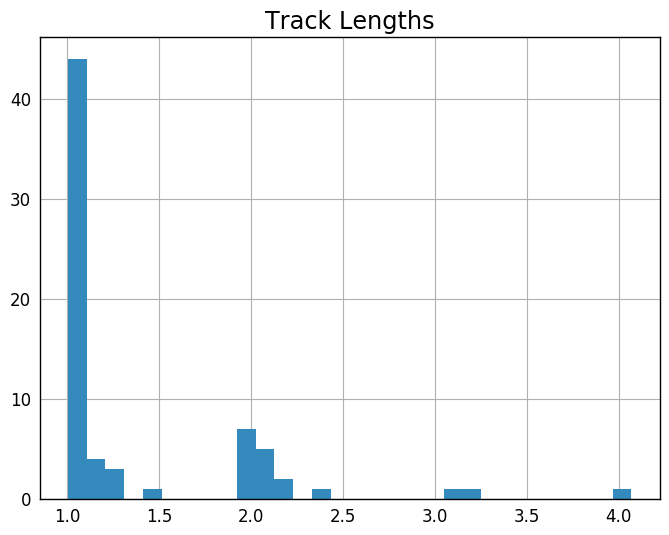

In [129]:
# Extract track lengths. We can use the slices for that

lengths = np.zeros(ntracks)

for ii in range(ntracks):
    dx = (events[ii][0].stop-events[ii][0].start)/12. # to roughly account for the binning. Unit would be AC-Pixels
    dy = events[ii][1].stop-events[ii][1].start
    lengths[ii] = np.sqrt(dx**2 + dy**2)

lhist = plt.hist(lengths,30)
plt.title("Track Lengths")

In [130]:
# Extract track electron count

events_e = np.zeros(ntracks)

for ii in range(ntracks):
    events_e[ii] = np.sum(cosmics[events[ii]])

Min: 1479.55229297
Max: 121419.591238


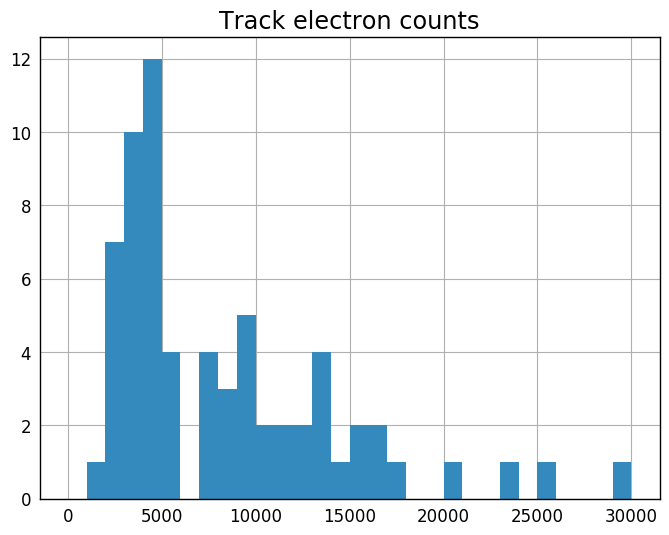

In [131]:
#ehist = plt.hist(events_e,100)
ehist = plt.hist(events_e,30,range=(0,30000)) # cut off the maximum energies - I want a comparison with
                                              # the simulator validation presentation
plt.title("Track electron counts")
print('Min:',np.min(events_e))
print('Max:',np.max(events_e))

This is already looking kind of like the example from the presentations, although since my statistics are really bad, I can only identify the maximum just below 5000.

There's also a pretty interesting outlier in energy!

To get energies, I need to convert electrons -> keV, but that's for later

Out of interest, let's see how track lengths and energy correlate:

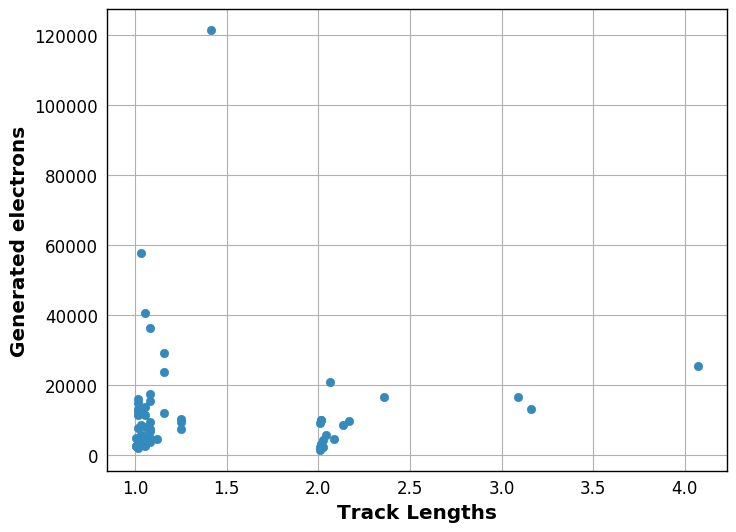

In [128]:
plt.scatter(lengths, events_e)
plt.xlabel("Track Lengths")
plt.ylabel("Generated electrons")

Answer: Well, the statistics are still pretty bad. You can kind of see something, but it's not very clear.